# XGBoost per Cluster
Goal: identify clusters and improve XGBoost performance by training seperate models for seperate clusters.  
- I use the same features that Katrine uses for XGBoost on all items.  
- I chose some features, transormed them into a two-dimensional space and chose clusters based on that. Since DBSCAN didn't return the clusters I had expected I chose them manually by eye.  
- I also did some parameter tuning. https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE as TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import interpn
import re
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from collections import defaultdict
from sklearn.model_selection import GridSearchCV
# from xgboost.sklearn import XGBClassifier
# from sklearn import cross_validation, metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [3]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 10})

In [5]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

## Data Preprocessing

In [6]:
# (currently unused)
def add_datepart(df, fldname, drop=True):
#     https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1
    """Add additional date information to dataframe"""
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
        
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9 
    if drop: df.drop(fldname, axis=1, inplace=True)

In [7]:
#load data
items = pd.read_csv('data/ex_items.csv', sep = '|', parse_dates=['dateFirstSell'])
items.head()
items_simple = items[['itemID', 'customerRating', 'manufacturer', 'brand', 'category1', 'category2', 'category3','recommendedRetailPrice', 'dateFirstSell', 'soldWeekly', 'soldMonthly']]
items_simple.category1 = pd.Categorical(items_simple.category1)
items_simple['category1'] = items_simple.category1.cat.codes
items_simple.category2 = pd.Categorical(items_simple.category2)
items_simple['category2'] = items_simple.category2.cat.codes
items_simple.category3 = pd.Categorical(items_simple.category3)
items_simple['category3'] = items_simple.category3.cat.codes
items_simple.head()
# load data
df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_train['date'] = [d.date() for d in df_train['time']]
df_test = pd.read_csv('data/orders0206_test.csv', sep='|', parse_dates=['time'])
df_test['date'] = [d.date() for d in df_test['time']]
df_items = pd.read_csv('data/items.csv', sep='|')
train = df_train
test = df_test
all_data = train.append(test)
# aggregate sales per day
aggregated = all_data.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
aggregated_sp = all_data.groupby(['itemID','date']).mean()["salesPrice"].to_frame().reset_index().rename(columns={'salesPrice':'avg_salesPrice'})
aggregated = pd.merge(aggregated,aggregated_sp,how='left')
aggregated.head()
import numpy as np
import re
# add additional date information
add_datepart(aggregated, 'date', drop = False)
add_datepart(aggregated, 'date', drop = False)
aggregated["WeekGroup"] = aggregated["Dayofyear"] // 14
from itertools import product
# Create "grid" with columns
index_cols = ['itemID', 'WeekGroup']

grid = []
for block_num in aggregated['WeekGroup'].unique():
    cur_items = aggregated.loc[aggregated['WeekGroup'] == block_num, 'itemID'].unique()
    grid.append(np.array(list(product(*[cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head()
train_m = aggregated.groupby(['WeekGroup','itemID']).agg({'count': 'sum','avg_salesPrice': np.mean}).reset_index()

# Merging sales numbers with the grid dataframe
train_m = pd.merge(grid,train_m,on=['WeekGroup','itemID'],how='left').fillna(0)
### add 0 sales for missing dates per itemID
for prod in train_m.itemID.unique():
    s = train_m.loc[train_m['itemID'] == prod][["WeekGroup","count","avg_salesPrice"]]
    s = s.set_index("WeekGroup")
    idx = range(s.index.min(), s.index.max()+1)
    s = s.reindex(idx)
#     s = s.reindex(idx, fill_value=0)
    if "df_week" not in globals():
        s["itemID"] = prod
        df_week = s
    else:
        s["itemID"] = prod
        df_week = pd.concat([df_week,s], ignore_index=False)
df_week.head(3)
df_week.reset_index(inplace=True)
df_week[df_week['itemID']==5]
df_week.sort_values(by=['itemID', 'WeekGroup'], inplace=True)
df_week['count'].fillna(value=0, inplace=True)
# df_week['avg_salesPrice'].fillna(value=df_week.groupby('itemID')['avg_salesPrice'].transform('mean'), inplace=True)
# df_week['avg_salesPrice'].fillna(value=0, inplace=True)
df_week['avg_salesPrice'].fillna(method='ffill', inplace=True)
# adding the category id too from the items table.
df_m = pd.merge(df_week,items_simple,on=['itemID'],how='left')
df_m['dateFirstSell'] = [d.month for d in df_m['dateFirstSell']]
df_m['retail_price_diff'] = df_m.apply(lambda x: (x.avg_salesPrice - x.recommendedRetailPrice)/x.recommendedRetailPrice, axis = 1)
df_m['price_fluctuate'] = df_m.groupby('itemID').avg_salesPrice.shift(1)
df_m['price_fluctuate'] = df_m.groupby('itemID')['price_fluctuate'].fillna(method='bfill')
df_m['price_fluctuate'] = df_m.apply(lambda x: 0 if x.price_fluctuate == x.avg_salesPrice 
                                     else (-1 if x.price_fluctuate > x.avg_salesPrice else 1), axis = 1)
groupcollist = ['brand','category1','category3']
aggregationlist = [('avg_salesPrice', np.mean, 'avg'),('count', np.sum, 'sum'),('count', np.mean, 'avg')]

for type_id in groupcollist:
    for column_id,aggregator,aggtype in aggregationlist:
        # get numbers from sales data and set column names
        mean_df = df_m.groupby([type_id,'WeekGroup']).aggregate(aggregator).reset_index()[[column_id,type_id,'WeekGroup']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'WeekGroup']
        # merge new columns on sales_m data
        df_m = pd.merge(df_m,mean_df,on=['WeekGroup',type_id],how='left')
        from sklearn.preprocessing import MinMaxScaler
# scale data between -1 & 1
scaler = MinMaxScaler()
scale_col = ['count', 'avg_salesPrice', 'customerRating', 'retail_price_diff', 
             'brand_avg_avg_salesPrice', 'brand_sum_count', 'brand_avg_count', 
             'category1_avg_avg_salesPrice', 'category1_sum_count', 'category1_avg_count', 
             'category3_avg_avg_salesPrice', 'category3_sum_count', 'category3_avg_count']
for c in scale_col:
    scaler.fit(df_m[[c]])
    df_m[c] = pd.DataFrame(scaler.transform(df_m[[c]]))[0]
lag_variables  = ['count','avg_salesPrice',
                  'brand_avg_avg_salesPrice','brand_sum_count','brand_avg_count',
#                   'manufacturer_avg_avg_salesPrice','manufacturer_sum_count','manufacturer_avg_count',
                  'category1_avg_avg_salesPrice','category1_sum_count','category1_avg_count',
                  'category3_avg_avg_salesPrice','category3_sum_count','category3_avg_count']
lags = [1 ,2 ,3, 4, 5]
# we will keep the results in thsi dataframe
sales_means = df_m.copy()
for lag in lags:
    sales_new_df = df_m.copy()
    sales_new_df.WeekGroup+=lag
    # subset only the lag variables we want
    sales_new_df = sales_new_df[['WeekGroup','itemID']+lag_variables]
    sales_new_df.columns = ['WeekGroup','itemID']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    # join with date_block_num,shop_id and item_id
    sales_means = pd.merge(sales_means, sales_new_df,on=['WeekGroup','itemID'] ,how='left')
for feat in sales_means.columns:
    if 'count' in feat:
        sales_means[feat]=sales_means[feat].fillna(0)
    elif 'salesPrice' or 'diff' in feat:
#         sales_means[feat]=sales_means[feat].fillna(sales_means[feat].median())
        sales_means[feat]=sales_means[feat].fillna(value=sales_means.groupby('itemID')[feat].transform('mean'))
cols_to_drop = lag_variables[1:] + ['recommendedRetailPrice', 'category2', 'retail_price_diff', 'price_fluctuate']
for col in cols_to_drop:
    del sales_means[col]
sales_means
X_train = sales_means[sales_means['WeekGroup']<9]
X_cv =  sales_means[sales_means['WeekGroup']==10]
X_test = sales_means[sales_means['WeekGroup']==11]
Y_train = X_train['count']
Y_cv = X_cv['count']
Y_test = X_test['count']
del X_train['count']
del X_cv['count']
del X_test['count']
del X_train['WeekGroup']
del X_cv['WeekGroup']
del X_test['WeekGroup']
# del X_train['itemID']
# del X_cv['itemID']

## Clustering

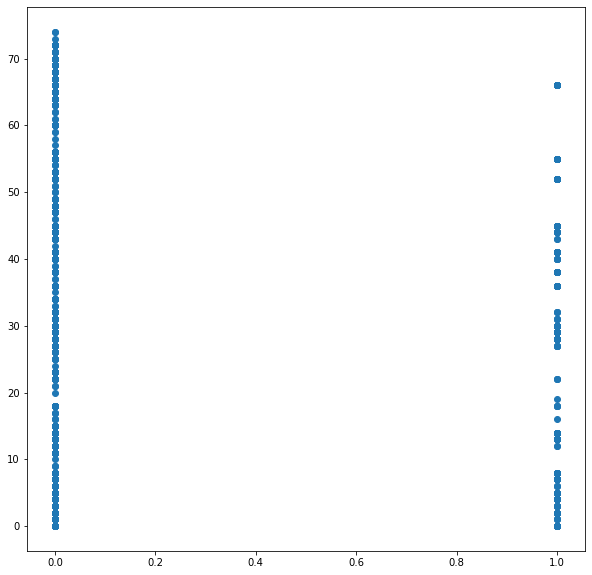

In [8]:
X_train_items = sales_means[["itemID","soldWeekly","category3"]].drop_duplicates().fillna(0)
X_train_items = X_train_items.reset_index()
X_train_items = X_train_items.drop(columns=["index"])
a_pca = PCA(n_components=2).fit_transform(X_train_items.drop(columns=["itemID"]))
df_pca = pd.DataFrame(data=a_pca) 
plot2 = plt.scatter( X_train_items["soldWeekly"], X_train_items["category3"])
# plot2.set(title="PCA-transformed Data")

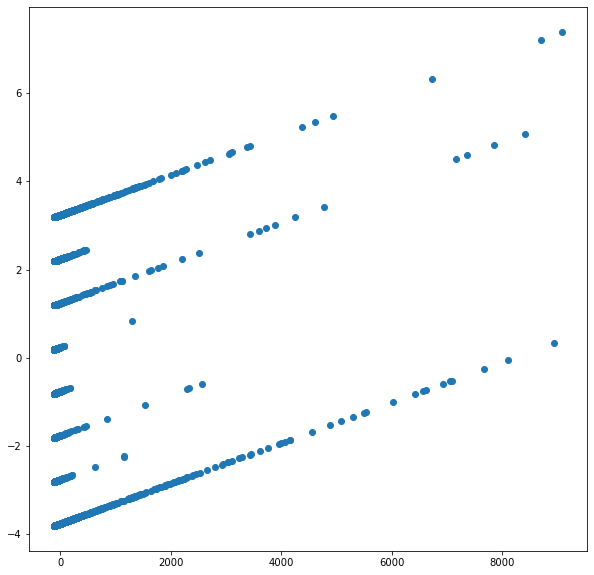

In [9]:
X_train_items = items[["itemID","category1","unitsSold","relRevenue","meanSalesPrice"]].drop_duplicates()
# X_train_items['dateFirstSell'] = [d.month for d in X_train_items['dateFirstSell']]
X_train_items = X_train_items.fillna(0)
scaler = MinMaxScaler()
scaler.fit(X_train_items[["unitsSold"]])
X_train_items["unitsSold"] = pd.DataFrame(scaler.transform(X_train_items[["unitsSold"]]))[0]
X_train_items = X_train_items.reset_index()
X_train_items = X_train_items.drop(columns=["index"])
a_pca = PCA(n_components=2).fit_transform(X_train_items.drop(columns=["itemID"]))
df_pca = pd.DataFrame(data=a_pca) 
plot2 = plt.scatter( df_pca[0], df_pca[1])
# plot2.set(title="PCA-transformed Data")

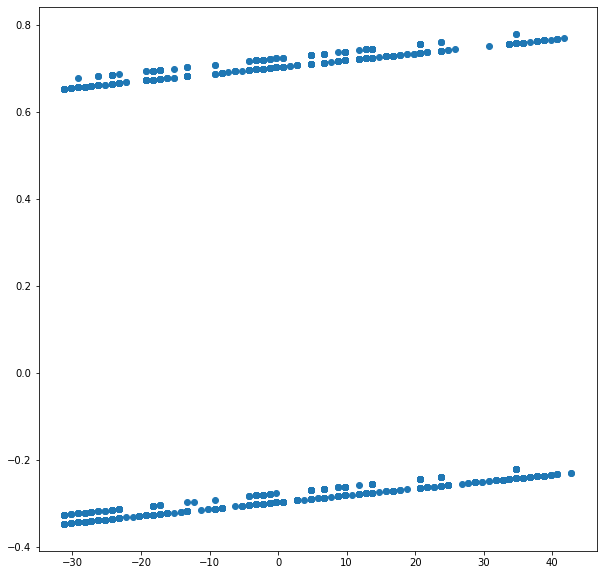

In [10]:
X_train_items = sales_means[["itemID","soldWeekly","soldMonthly","category3"]].drop_duplicates().fillna(0)
X_train_items = X_train_items.reset_index()
X_train_items = X_train_items.drop(columns=["index"])
a_pca = PCA(n_components=2).fit_transform(X_train_items.drop(columns=["itemID"]))
df_pca = pd.DataFrame(data=a_pca) 
plot2 = plt.scatter( df_pca[0], df_pca[1])
# plot2.set(title="PCA-transformed Data")

In [11]:
X_train_items = sales_means[["itemID","soldWeekly","soldMonthly","category1","category3","dateFirstSell"]].drop_duplicates().fillna(0)
X_train_items = X_train_items.reset_index()
X_train_items = X_train_items.drop(columns=["index"])

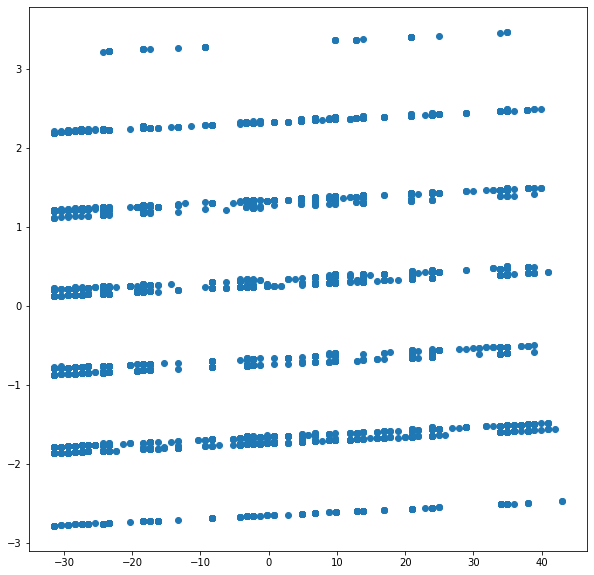

In [12]:
a_pca = PCA(n_components=2).fit_transform(X_train_items.drop(columns=["itemID"]))
df_pca = pd.DataFrame(data=a_pca) 
plot2 = plt.scatter( df_pca[0], df_pca[1])
# plot2.set(title="PCA-transformed Data")

In [56]:
clusterer = DBSCAN(min_samples=3, eps=1.5)#, metric='euclidean')

# create the clustering
clusters = clusterer.fit(df_pca)

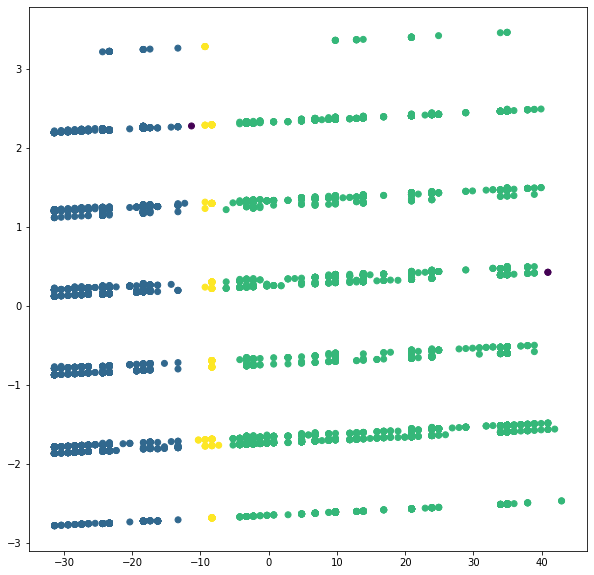

In [57]:
plt.scatter(df_pca[0],df_pca[1], c=clusters.labels_)

In [14]:
from sklearn.cluster import KMeans
estimator = KMeans(n_clusters = 6)
cluster = estimator.fit(df_pca[[0,1]])
cluster_ids = estimator.predict(df_pca[[0,1]])

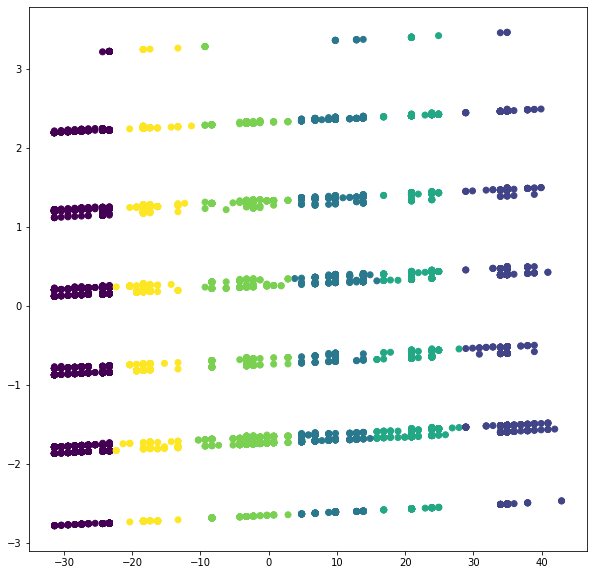

In [42]:
plt.scatter(df_pca[0],df_pca[1], c=cluster_ids)

In [16]:
df_pca["itemID"] = X_train_items.itemID

In [17]:
df_pca["cluster"] = df_pca.apply(lambda x: 1 if x[1] > 2.5 else 2 if x[1] > 1.5 else 3 if x[1] > 0.5 else 4 if x[1] > -0.5 else 5 if x[1] > -1.5 else 6 , axis = 1)

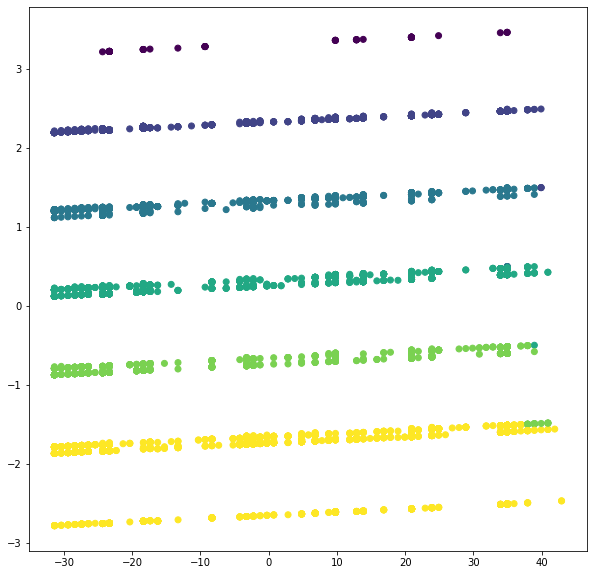

In [18]:
plt.scatter(df_pca[0],df_pca[1], c=df_pca.cluster)

In [19]:
# pd.merge(df_pca[["cluster","itemID"]], X_train,  how="right")
df_pca = df_pca.set_index("itemID")
X_train = X_train.join(df_pca[["cluster"]], on='itemID', how="left")
X_train.cluster = X_train.cluster.fillna(0)

In [20]:
X_train.cluster = X_train.cluster.fillna(0)

In [21]:
X_test = X_test.join(df_pca[["cluster"]], on='itemID', how="left")
X_test.cluster = X_test.cluster.fillna(0)

In [22]:
X_cv = X_cv.join(df_pca[["cluster"]], on='itemID', how="left")
X_cv.cluster = X_cv.cluster.fillna(0)

In [23]:
X_train.groupby("cluster").count()

,itemID,customerRating,manufacturer,brand,category1,category3,dateFirstSell,soldWeekly,soldMonthly,count_lag_1,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
cluster,,,,,,,,,,,,,,,,,,,,,
2,280,280,280,280,280,280,280,280,280,280,...,0,0,280,280,0,280,280,0,280,280
3,2640,2640,2640,2640,2640,2640,2640,2640,2640,2640,...,393,393,2640,2640,393,2640,2640,393,2640,2640
4,6095,6095,6095,6095,6095,6095,6095,6095,6095,6095,...,3840,3840,6095,6095,3840,6095,6095,3840,6095,6095
5,5182,5182,5182,5182,5182,5182,5182,5182,5182,5182,...,4139,4139,5182,5182,4139,5182,5182,4139,5182,5182
6,17041,17041,17041,17041,17041,17041,17041,17041,17041,17041,...,16067,16067,17041,17041,16067,17041,17041,16067,17041,17041


In [24]:
del X_train['itemID']
del X_cv['itemID']

## Parameter Tuning

In [25]:
# from sklearn.model_selection import GridSearchCV
# xgb1 = XGBRegressor()
# parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:linear'],
#               'learning_rate': [.01], #so called `eta` value
#               'max_depth': [5],
#               'min_child_weight': [300],
#               'silent': [1],
#               'subsample': [ 0.7,0.8],
#               'colsample_bytree': [ 0.8,0.9],
#               'n_estimators': [1000],
#               'eta': [0.01, 0.3],
#               'seed': [40,42]}


# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 2,
#                         n_jobs = 8,
#                         verbose=True)

# xgb_grid.fit(x_train_category,
#          y_train_category)
# #     print("Cluster: " + str(cluster))
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

In [26]:
X_train.groupby("cluster").count()

,customerRating,manufacturer,brand,category1,category3,dateFirstSell,soldWeekly,soldMonthly,count_lag_1,avg_salesPrice_lag_1,...,avg_salesPrice_lag_5,brand_avg_avg_salesPrice_lag_5,brand_sum_count_lag_5,brand_avg_count_lag_5,category1_avg_avg_salesPrice_lag_5,category1_sum_count_lag_5,category1_avg_count_lag_5,category3_avg_avg_salesPrice_lag_5,category3_sum_count_lag_5,category3_avg_count_lag_5
cluster,,,,,,,,,,,,,,,,,,,,,
2,280,280,280,280,280,280,280,280,280,246,...,0,0,280,280,0,280,280,0,280,280
3,2640,2640,2640,2640,2640,2640,2640,2640,2640,2380,...,393,393,2640,2640,393,2640,2640,393,2640,2640
4,6095,6095,6095,6095,6095,6095,6095,6095,6095,5801,...,3840,3840,6095,6095,3840,6095,6095,3840,6095,6095
5,5182,5182,5182,5182,5182,5182,5182,5182,5182,5084,...,4139,4139,5182,5182,4139,5182,5182,4139,5182,5182
6,17041,17041,17041,17041,17041,17041,17041,17041,17041,16890,...,16067,16067,17041,17041,16067,17041,17041,16067,17041,17041


In [29]:
y_xgboost_cat = dict()
for cluster in df_pca.cluster.unique(): 
    x_train_category = X_train[X_train.cluster == cluster].drop(columns=["cluster"])
    y_train_category = Y_train.to_frame()[Y_train.to_frame().index.isin(list(x_train_category.index))].squeeze()
    X_cv_category = X_cv[X_cv.cluster == cluster].drop(columns=["cluster"])
    Y_cv_category = Y_cv.to_frame()[Y_cv.to_frame().index.isin(list(X_cv_category.index))].squeeze()
    
    
    # parameter optimization [todo]
    model = XGBRegressor(
        colsample_bytree= 0.9, 
     eta= 0.3, 
     learning_rate= 0.01, 
     max_depth= 5, 
    min_child_weight= 300, 
    n_estimators= 1000, 
    nthread= 4, 
    objective= 'reg:linear', 
    seed= 40, 
    silent= 1,
    subsample= 0.7)
        
    # train the model
    model.fit(
        x_train_category, 
        y_train_category, 
        eval_metric="rmse", 
        eval_set=[(x_train_category, y_train_category), (X_cv_category, Y_cv_category)], 
        verbose=True, 
        early_stopping_rounds = 10)
    
    # apply to unseen data

    for prod in X_test[X_test.cluster == cluster].itemID.unique():
        train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID',"cluster"], axis=1))))).rename(columns={0:'predicted_count'})
        train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
        y_xgboost_cat[prod] = int(train_predict["predicted_count"].sum().round())

[0]	validation_0-rmse:0.48732	validation_1-rmse:0.48645
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48247	validation_1-rmse:0.48162
[2]	validation_0-rmse:0.47767	validation_1-rmse:0.47682
[3]	validation_0-rmse:0.47292	validation_1-rmse:0.47209
[4]	validation_0-rmse:0.46822	validation_1-rmse:0.46740
[5]	validation_0-rmse:0.46357	validation_1-rmse:0.46275
[6]	validation_0-rmse:0.45895	validation_1-rmse:0.45815
[7]	validation_0-rmse:0.45439	validation_1-rmse:0.45360
[8]	validation_0-rmse:0.44988	validation_1-rmse:0.44909
[9]	validation_0-rmse:0.44540	validation_1-rmse:0.44463
[10]	validation_0-rmse:0.44097	validation_1-rmse:0.44022
[11]	validation_0-rmse:0.43659	validation_1-rmse:0.43584
[12]	validation_0-rmse:0.43226	validation_1-rmse:0.43152
[13]	validation_0-rmse:0.42796	validation_1-rmse:0.42724
[14]	validation_0-rmse:0.42371	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12260	validation_1-rmse:0.12206
[142]	validation_0-rmse:0.12146	validation_1-rmse:0.12093
[143]	validation_0-rmse:0.12034	validation_1-rmse:0.11980
[144]	validation_0-rmse:0.11923	validation_1-rmse:0.11869
[145]	validation_0-rmse:0.11813	validation_1-rmse:0.11759
[146]	validation_0-rmse:0.11705	validation_1-rmse:0.11650
[147]	validation_0-rmse:0.11597	validation_1-rmse:0.11541
[148]	validation_0-rmse:0.11491	validation_1-rmse:0.11434
[149]	validation_0-rmse:0.11385	validation_1-rmse:0.11328
[150]	validation_0-rmse:0.11281	validation_1-rmse:0.11223
[151]	validation_0-rmse:0.11179	validation_1-rmse:0.11119
[152]	validation_0-rmse:0.11077	validation_1-rmse:0.11017
[153]	validation_0-rmse:0.10976	validation_1-rmse:0.10916
[154]	validation_0-rmse:0.10877	validation_1-rmse:0.10816
[155]	validation_0-rmse:0.10778	validation_1-rmse:0.10717
[156]	validation_0-rmse:0.10681	validation_1-rmse:0.10619
[157]	validation_0-rmse:0.10584	validation_1-rmse:0.10522
[158]	validati

[283]	validation_0-rmse:0.04344	validation_1-rmse:0.04290
[284]	validation_0-rmse:0.04326	validation_1-rmse:0.04271
[285]	validation_0-rmse:0.04307	validation_1-rmse:0.04253
[286]	validation_0-rmse:0.04289	validation_1-rmse:0.04234
[287]	validation_0-rmse:0.04271	validation_1-rmse:0.04216
[288]	validation_0-rmse:0.04254	validation_1-rmse:0.04198
[289]	validation_0-rmse:0.04236	validation_1-rmse:0.04181
[290]	validation_0-rmse:0.04219	validation_1-rmse:0.04163
[291]	validation_0-rmse:0.04203	validation_1-rmse:0.04147
[292]	validation_0-rmse:0.04186	validation_1-rmse:0.04132
[293]	validation_0-rmse:0.04170	validation_1-rmse:0.04116
[294]	validation_0-rmse:0.04154	validation_1-rmse:0.04100
[295]	validation_0-rmse:0.04138	validation_1-rmse:0.04084
[296]	validation_0-rmse:0.04123	validation_1-rmse:0.04069
[297]	validation_0-rmse:0.04108	validation_1-rmse:0.04054
[298]	validation_0-rmse:0.04092	validation_1-rmse:0.04040
[299]	validation_0-rmse:0.04078	validation_1-rmse:0.04025
[300]	validati

[425]	validation_0-rmse:0.03322	validation_1-rmse:0.03302
[426]	validation_0-rmse:0.03320	validation_1-rmse:0.03301
[427]	validation_0-rmse:0.03318	validation_1-rmse:0.03299
[428]	validation_0-rmse:0.03317	validation_1-rmse:0.03298
[429]	validation_0-rmse:0.03315	validation_1-rmse:0.03297
[430]	validation_0-rmse:0.03314	validation_1-rmse:0.03295
[431]	validation_0-rmse:0.03313	validation_1-rmse:0.03294
[432]	validation_0-rmse:0.03311	validation_1-rmse:0.03293
[433]	validation_0-rmse:0.03310	validation_1-rmse:0.03291
[434]	validation_0-rmse:0.03308	validation_1-rmse:0.03290
[435]	validation_0-rmse:0.03307	validation_1-rmse:0.03289
[436]	validation_0-rmse:0.03306	validation_1-rmse:0.03288
[437]	validation_0-rmse:0.03304	validation_1-rmse:0.03287
[438]	validation_0-rmse:0.03303	validation_1-rmse:0.03286
[439]	validation_0-rmse:0.03302	validation_1-rmse:0.03285
[440]	validation_0-rmse:0.03300	validation_1-rmse:0.03284
[441]	validation_0-rmse:0.03299	validation_1-rmse:0.03282
[442]	validati

[567]	validation_0-rmse:0.03224	validation_1-rmse:0.03233
[568]	validation_0-rmse:0.03224	validation_1-rmse:0.03233
[569]	validation_0-rmse:0.03224	validation_1-rmse:0.03233
[570]	validation_0-rmse:0.03224	validation_1-rmse:0.03233
[571]	validation_0-rmse:0.03223	validation_1-rmse:0.03233
[572]	validation_0-rmse:0.03223	validation_1-rmse:0.03233
[573]	validation_0-rmse:0.03223	validation_1-rmse:0.03233
[574]	validation_0-rmse:0.03222	validation_1-rmse:0.03233
[575]	validation_0-rmse:0.03222	validation_1-rmse:0.03233
[576]	validation_0-rmse:0.03222	validation_1-rmse:0.03233
[577]	validation_0-rmse:0.03222	validation_1-rmse:0.03233
[578]	validation_0-rmse:0.03222	validation_1-rmse:0.03233
[579]	validation_0-rmse:0.03221	validation_1-rmse:0.03233
[580]	validation_0-rmse:0.03221	validation_1-rmse:0.03233
[581]	validation_0-rmse:0.03221	validation_1-rmse:0.03233
[582]	validation_0-rmse:0.03221	validation_1-rmse:0.03233
[583]	validation_0-rmse:0.03220	validation_1-rmse:0.03234
[584]	validati

[121]	validation_0-rmse:0.14651	validation_1-rmse:0.14824
[122]	validation_0-rmse:0.14509	validation_1-rmse:0.14679
[123]	validation_0-rmse:0.14368	validation_1-rmse:0.14535
[124]	validation_0-rmse:0.14228	validation_1-rmse:0.14392
[125]	validation_0-rmse:0.14090	validation_1-rmse:0.14252
[126]	validation_0-rmse:0.13954	validation_1-rmse:0.14112
[127]	validation_0-rmse:0.13818	validation_1-rmse:0.13976
[128]	validation_0-rmse:0.13684	validation_1-rmse:0.13838
[129]	validation_0-rmse:0.13552	validation_1-rmse:0.13703
[130]	validation_0-rmse:0.13420	validation_1-rmse:0.13568
[131]	validation_0-rmse:0.13291	validation_1-rmse:0.13436
[132]	validation_0-rmse:0.13162	validation_1-rmse:0.13305
[133]	validation_0-rmse:0.13035	validation_1-rmse:0.13175
[134]	validation_0-rmse:0.12909	validation_1-rmse:0.13046
[135]	validation_0-rmse:0.12784	validation_1-rmse:0.12920
[136]	validation_0-rmse:0.12661	validation_1-rmse:0.12795
[137]	validation_0-rmse:0.12539	validation_1-rmse:0.12672
[138]	validati

[263]	validation_0-rmse:0.04208	validation_1-rmse:0.03905
[264]	validation_0-rmse:0.04179	validation_1-rmse:0.03872
[265]	validation_0-rmse:0.04151	validation_1-rmse:0.03840
[266]	validation_0-rmse:0.04123	validation_1-rmse:0.03808
[267]	validation_0-rmse:0.04095	validation_1-rmse:0.03776
[268]	validation_0-rmse:0.04068	validation_1-rmse:0.03743
[269]	validation_0-rmse:0.04041	validation_1-rmse:0.03712
[270]	validation_0-rmse:0.04015	validation_1-rmse:0.03681
[271]	validation_0-rmse:0.03988	validation_1-rmse:0.03651
[272]	validation_0-rmse:0.03962	validation_1-rmse:0.03621
[273]	validation_0-rmse:0.03936	validation_1-rmse:0.03591
[274]	validation_0-rmse:0.03911	validation_1-rmse:0.03560
[275]	validation_0-rmse:0.03886	validation_1-rmse:0.03528
[276]	validation_0-rmse:0.03861	validation_1-rmse:0.03500
[277]	validation_0-rmse:0.03837	validation_1-rmse:0.03471
[278]	validation_0-rmse:0.03813	validation_1-rmse:0.03442
[279]	validation_0-rmse:0.03789	validation_1-rmse:0.03413
[280]	validati

[405]	validation_0-rmse:0.02468	validation_1-rmse:0.01588
[406]	validation_0-rmse:0.02465	validation_1-rmse:0.01583
[407]	validation_0-rmse:0.02462	validation_1-rmse:0.01577
[408]	validation_0-rmse:0.02459	validation_1-rmse:0.01573
[409]	validation_0-rmse:0.02457	validation_1-rmse:0.01567
[410]	validation_0-rmse:0.02454	validation_1-rmse:0.01563
[411]	validation_0-rmse:0.02451	validation_1-rmse:0.01558
[412]	validation_0-rmse:0.02448	validation_1-rmse:0.01553
[413]	validation_0-rmse:0.02446	validation_1-rmse:0.01548
[414]	validation_0-rmse:0.02443	validation_1-rmse:0.01544
[415]	validation_0-rmse:0.02440	validation_1-rmse:0.01539
[416]	validation_0-rmse:0.02438	validation_1-rmse:0.01534
[417]	validation_0-rmse:0.02435	validation_1-rmse:0.01528
[418]	validation_0-rmse:0.02432	validation_1-rmse:0.01524
[419]	validation_0-rmse:0.02430	validation_1-rmse:0.01519
[420]	validation_0-rmse:0.02428	validation_1-rmse:0.01513
[421]	validation_0-rmse:0.02425	validation_1-rmse:0.01509
[422]	validati

[547]	validation_0-rmse:0.02300	validation_1-rmse:0.01264
[548]	validation_0-rmse:0.02299	validation_1-rmse:0.01264
[549]	validation_0-rmse:0.02299	validation_1-rmse:0.01263
[550]	validation_0-rmse:0.02299	validation_1-rmse:0.01262
[551]	validation_0-rmse:0.02298	validation_1-rmse:0.01261
[552]	validation_0-rmse:0.02298	validation_1-rmse:0.01260
[553]	validation_0-rmse:0.02298	validation_1-rmse:0.01260
[554]	validation_0-rmse:0.02297	validation_1-rmse:0.01259
[555]	validation_0-rmse:0.02297	validation_1-rmse:0.01259
[556]	validation_0-rmse:0.02297	validation_1-rmse:0.01259
[557]	validation_0-rmse:0.02296	validation_1-rmse:0.01258
[558]	validation_0-rmse:0.02296	validation_1-rmse:0.01258
[559]	validation_0-rmse:0.02296	validation_1-rmse:0.01258
[560]	validation_0-rmse:0.02296	validation_1-rmse:0.01257
[561]	validation_0-rmse:0.02295	validation_1-rmse:0.01257
[562]	validation_0-rmse:0.02295	validation_1-rmse:0.01256
[563]	validation_0-rmse:0.02295	validation_1-rmse:0.01256
[564]	validati

[689]	validation_0-rmse:0.02268	validation_1-rmse:0.01227
[690]	validation_0-rmse:0.02268	validation_1-rmse:0.01227
[691]	validation_0-rmse:0.02268	validation_1-rmse:0.01227
[692]	validation_0-rmse:0.02268	validation_1-rmse:0.01227
[693]	validation_0-rmse:0.02268	validation_1-rmse:0.01227
[694]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[695]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[696]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[697]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[698]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[699]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[700]	validation_0-rmse:0.02267	validation_1-rmse:0.01227
[701]	validation_0-rmse:0.02266	validation_1-rmse:0.01227
[702]	validation_0-rmse:0.02266	validation_1-rmse:0.01227
[703]	validation_0-rmse:0.02266	validation_1-rmse:0.01227
[704]	validation_0-rmse:0.02266	validation_1-rmse:0.01227
[705]	validation_0-rmse:0.02266	validation_1-rmse:0.01227
[706]	validati

[116]	validation_0-rmse:0.15273	validation_1-rmse:0.16540
[117]	validation_0-rmse:0.15129	validation_1-rmse:0.16398
[118]	validation_0-rmse:0.14986	validation_1-rmse:0.16254
[119]	validation_0-rmse:0.14845	validation_1-rmse:0.16111
[120]	validation_0-rmse:0.14705	validation_1-rmse:0.15971
[121]	validation_0-rmse:0.14568	validation_1-rmse:0.15830
[122]	validation_0-rmse:0.14431	validation_1-rmse:0.15692
[123]	validation_0-rmse:0.14296	validation_1-rmse:0.15554
[124]	validation_0-rmse:0.14162	validation_1-rmse:0.15413
[125]	validation_0-rmse:0.14029	validation_1-rmse:0.15277
[126]	validation_0-rmse:0.13898	validation_1-rmse:0.15144
[127]	validation_0-rmse:0.13768	validation_1-rmse:0.15014
[128]	validation_0-rmse:0.13640	validation_1-rmse:0.14884
[129]	validation_0-rmse:0.13512	validation_1-rmse:0.14756
[130]	validation_0-rmse:0.13388	validation_1-rmse:0.14624
[131]	validation_0-rmse:0.13264	validation_1-rmse:0.14500
[132]	validation_0-rmse:0.13142	validation_1-rmse:0.14375
[133]	validati

[258]	validation_0-rmse:0.05016	validation_1-rmse:0.06067
[259]	validation_0-rmse:0.04990	validation_1-rmse:0.06040
[260]	validation_0-rmse:0.04965	validation_1-rmse:0.06013
[261]	validation_0-rmse:0.04940	validation_1-rmse:0.05987
[262]	validation_0-rmse:0.04915	validation_1-rmse:0.05960
[263]	validation_0-rmse:0.04890	validation_1-rmse:0.05935
[264]	validation_0-rmse:0.04867	validation_1-rmse:0.05909
[265]	validation_0-rmse:0.04843	validation_1-rmse:0.05884
[266]	validation_0-rmse:0.04819	validation_1-rmse:0.05857
[267]	validation_0-rmse:0.04796	validation_1-rmse:0.05832
[268]	validation_0-rmse:0.04773	validation_1-rmse:0.05807
[269]	validation_0-rmse:0.04751	validation_1-rmse:0.05782
[270]	validation_0-rmse:0.04729	validation_1-rmse:0.05758
[271]	validation_0-rmse:0.04707	validation_1-rmse:0.05734
[272]	validation_0-rmse:0.04686	validation_1-rmse:0.05713
[273]	validation_0-rmse:0.04666	validation_1-rmse:0.05690
[274]	validation_0-rmse:0.04645	validation_1-rmse:0.05664
[275]	validati

[400]	validation_0-rmse:0.03555	validation_1-rmse:0.04287
[401]	validation_0-rmse:0.03553	validation_1-rmse:0.04282
[402]	validation_0-rmse:0.03551	validation_1-rmse:0.04279
[403]	validation_0-rmse:0.03548	validation_1-rmse:0.04275
[404]	validation_0-rmse:0.03546	validation_1-rmse:0.04271
[405]	validation_0-rmse:0.03544	validation_1-rmse:0.04265
[406]	validation_0-rmse:0.03542	validation_1-rmse:0.04262
[407]	validation_0-rmse:0.03539	validation_1-rmse:0.04257
[408]	validation_0-rmse:0.03537	validation_1-rmse:0.04253
[409]	validation_0-rmse:0.03535	validation_1-rmse:0.04251
[410]	validation_0-rmse:0.03533	validation_1-rmse:0.04246
[411]	validation_0-rmse:0.03531	validation_1-rmse:0.04242
[412]	validation_0-rmse:0.03528	validation_1-rmse:0.04240
[413]	validation_0-rmse:0.03527	validation_1-rmse:0.04238
[414]	validation_0-rmse:0.03525	validation_1-rmse:0.04235
[415]	validation_0-rmse:0.03523	validation_1-rmse:0.04231
[416]	validation_0-rmse:0.03521	validation_1-rmse:0.04228
[417]	validati

[542]	validation_0-rmse:0.03411	validation_1-rmse:0.04015
[543]	validation_0-rmse:0.03411	validation_1-rmse:0.04014
[544]	validation_0-rmse:0.03410	validation_1-rmse:0.04013
[545]	validation_0-rmse:0.03410	validation_1-rmse:0.04012
[546]	validation_0-rmse:0.03409	validation_1-rmse:0.04011
[547]	validation_0-rmse:0.03409	validation_1-rmse:0.04010
[548]	validation_0-rmse:0.03408	validation_1-rmse:0.04009
[549]	validation_0-rmse:0.03408	validation_1-rmse:0.04008
[550]	validation_0-rmse:0.03407	validation_1-rmse:0.04008
[551]	validation_0-rmse:0.03407	validation_1-rmse:0.04007
[552]	validation_0-rmse:0.03407	validation_1-rmse:0.04006
[553]	validation_0-rmse:0.03406	validation_1-rmse:0.04004
[554]	validation_0-rmse:0.03406	validation_1-rmse:0.04003
[555]	validation_0-rmse:0.03406	validation_1-rmse:0.04004
[556]	validation_0-rmse:0.03405	validation_1-rmse:0.04002
[557]	validation_0-rmse:0.03405	validation_1-rmse:0.04002
[558]	validation_0-rmse:0.03405	validation_1-rmse:0.04003
[559]	validati

[684]	validation_0-rmse:0.03368	validation_1-rmse:0.03965
[685]	validation_0-rmse:0.03368	validation_1-rmse:0.03964
[686]	validation_0-rmse:0.03368	validation_1-rmse:0.03963
[687]	validation_0-rmse:0.03367	validation_1-rmse:0.03964
[688]	validation_0-rmse:0.03367	validation_1-rmse:0.03964
[689]	validation_0-rmse:0.03367	validation_1-rmse:0.03963
[690]	validation_0-rmse:0.03367	validation_1-rmse:0.03963
[691]	validation_0-rmse:0.03366	validation_1-rmse:0.03963
[692]	validation_0-rmse:0.03366	validation_1-rmse:0.03963
[693]	validation_0-rmse:0.03366	validation_1-rmse:0.03963
[694]	validation_0-rmse:0.03365	validation_1-rmse:0.03962
[695]	validation_0-rmse:0.03365	validation_1-rmse:0.03962
[696]	validation_0-rmse:0.03365	validation_1-rmse:0.03961
[697]	validation_0-rmse:0.03365	validation_1-rmse:0.03961
[698]	validation_0-rmse:0.03365	validation_1-rmse:0.03961
[699]	validation_0-rmse:0.03364	validation_1-rmse:0.03961
[700]	validation_0-rmse:0.03364	validation_1-rmse:0.03961
[701]	validati

[50]	validation_0-rmse:0.29294	validation_1-rmse:0.29920
[51]	validation_0-rmse:0.29005	validation_1-rmse:0.29627
[52]	validation_0-rmse:0.28719	validation_1-rmse:0.29338
[53]	validation_0-rmse:0.28437	validation_1-rmse:0.29055
[54]	validation_0-rmse:0.28156	validation_1-rmse:0.28774
[55]	validation_0-rmse:0.27879	validation_1-rmse:0.28492
[56]	validation_0-rmse:0.27604	validation_1-rmse:0.28215
[57]	validation_0-rmse:0.27332	validation_1-rmse:0.27937
[58]	validation_0-rmse:0.27063	validation_1-rmse:0.27665
[59]	validation_0-rmse:0.26797	validation_1-rmse:0.27396
[60]	validation_0-rmse:0.26533	validation_1-rmse:0.27128
[61]	validation_0-rmse:0.26272	validation_1-rmse:0.26861
[62]	validation_0-rmse:0.26013	validation_1-rmse:0.26597
[63]	validation_0-rmse:0.25758	validation_1-rmse:0.26336
[64]	validation_0-rmse:0.25504	validation_1-rmse:0.26079
[65]	validation_0-rmse:0.25254	validation_1-rmse:0.25826
[66]	validation_0-rmse:0.25006	validation_1-rmse:0.25572
[67]	validation_0-rmse:0.24760	

[193]	validation_0-rmse:0.07617	validation_1-rmse:0.07648
[194]	validation_0-rmse:0.07554	validation_1-rmse:0.07580
[195]	validation_0-rmse:0.07491	validation_1-rmse:0.07511
[196]	validation_0-rmse:0.07429	validation_1-rmse:0.07443
[197]	validation_0-rmse:0.07369	validation_1-rmse:0.07377
[198]	validation_0-rmse:0.07308	validation_1-rmse:0.07313
[199]	validation_0-rmse:0.07249	validation_1-rmse:0.07248
[200]	validation_0-rmse:0.07190	validation_1-rmse:0.07182
[201]	validation_0-rmse:0.07132	validation_1-rmse:0.07118
[202]	validation_0-rmse:0.07075	validation_1-rmse:0.07052
[203]	validation_0-rmse:0.07017	validation_1-rmse:0.06989
[204]	validation_0-rmse:0.06961	validation_1-rmse:0.06925
[205]	validation_0-rmse:0.06906	validation_1-rmse:0.06865
[206]	validation_0-rmse:0.06851	validation_1-rmse:0.06803
[207]	validation_0-rmse:0.06797	validation_1-rmse:0.06742
[208]	validation_0-rmse:0.06744	validation_1-rmse:0.06684
[209]	validation_0-rmse:0.06691	validation_1-rmse:0.06626
[210]	validati

[335]	validation_0-rmse:0.03486	validation_1-rmse:0.02569
[336]	validation_0-rmse:0.03478	validation_1-rmse:0.02553
[337]	validation_0-rmse:0.03470	validation_1-rmse:0.02540
[338]	validation_0-rmse:0.03462	validation_1-rmse:0.02525
[339]	validation_0-rmse:0.03454	validation_1-rmse:0.02511
[340]	validation_0-rmse:0.03446	validation_1-rmse:0.02496
[341]	validation_0-rmse:0.03438	validation_1-rmse:0.02482
[342]	validation_0-rmse:0.03431	validation_1-rmse:0.02469
[343]	validation_0-rmse:0.03423	validation_1-rmse:0.02457
[344]	validation_0-rmse:0.03416	validation_1-rmse:0.02443
[345]	validation_0-rmse:0.03409	validation_1-rmse:0.02431
[346]	validation_0-rmse:0.03402	validation_1-rmse:0.02419
[347]	validation_0-rmse:0.03395	validation_1-rmse:0.02406
[348]	validation_0-rmse:0.03388	validation_1-rmse:0.02392
[349]	validation_0-rmse:0.03381	validation_1-rmse:0.02380
[350]	validation_0-rmse:0.03374	validation_1-rmse:0.02367
[351]	validation_0-rmse:0.03367	validation_1-rmse:0.02355
[352]	validati

[477]	validation_0-rmse:0.03031	validation_1-rmse:0.01640
[478]	validation_0-rmse:0.03030	validation_1-rmse:0.01639
[479]	validation_0-rmse:0.03030	validation_1-rmse:0.01637
[480]	validation_0-rmse:0.03029	validation_1-rmse:0.01636
[481]	validation_0-rmse:0.03028	validation_1-rmse:0.01633
[482]	validation_0-rmse:0.03027	validation_1-rmse:0.01631
[483]	validation_0-rmse:0.03027	validation_1-rmse:0.01630
[484]	validation_0-rmse:0.03026	validation_1-rmse:0.01628
[485]	validation_0-rmse:0.03025	validation_1-rmse:0.01624
[486]	validation_0-rmse:0.03024	validation_1-rmse:0.01622
[487]	validation_0-rmse:0.03023	validation_1-rmse:0.01621
[488]	validation_0-rmse:0.03023	validation_1-rmse:0.01619
[489]	validation_0-rmse:0.03022	validation_1-rmse:0.01617
[490]	validation_0-rmse:0.03021	validation_1-rmse:0.01616
[491]	validation_0-rmse:0.03021	validation_1-rmse:0.01615
[492]	validation_0-rmse:0.03020	validation_1-rmse:0.01612
[493]	validation_0-rmse:0.03020	validation_1-rmse:0.01610
[494]	validati

[619]	validation_0-rmse:0.02966	validation_1-rmse:0.01513
[620]	validation_0-rmse:0.02965	validation_1-rmse:0.01512
[621]	validation_0-rmse:0.02965	validation_1-rmse:0.01511
[622]	validation_0-rmse:0.02965	validation_1-rmse:0.01512
[623]	validation_0-rmse:0.02965	validation_1-rmse:0.01511
[624]	validation_0-rmse:0.02964	validation_1-rmse:0.01510
[625]	validation_0-rmse:0.02964	validation_1-rmse:0.01510
[626]	validation_0-rmse:0.02964	validation_1-rmse:0.01510
[627]	validation_0-rmse:0.02963	validation_1-rmse:0.01509
[628]	validation_0-rmse:0.02963	validation_1-rmse:0.01508
[629]	validation_0-rmse:0.02963	validation_1-rmse:0.01508
[630]	validation_0-rmse:0.02963	validation_1-rmse:0.01507
[631]	validation_0-rmse:0.02962	validation_1-rmse:0.01507
[632]	validation_0-rmse:0.02962	validation_1-rmse:0.01507
[633]	validation_0-rmse:0.02962	validation_1-rmse:0.01506
[634]	validation_0-rmse:0.02962	validation_1-rmse:0.01506
[635]	validation_0-rmse:0.02961	validation_1-rmse:0.01506
[636]	validati

[92]	validation_0-rmse:0.19276	validation_1-rmse:0.19252
[93]	validation_0-rmse:0.19092	validation_1-rmse:0.19068
[94]	validation_0-rmse:0.18906	validation_1-rmse:0.18883
[95]	validation_0-rmse:0.18725	validation_1-rmse:0.18703
[96]	validation_0-rmse:0.18547	validation_1-rmse:0.18526
[97]	validation_0-rmse:0.18369	validation_1-rmse:0.18350
[98]	validation_0-rmse:0.18192	validation_1-rmse:0.18173
[99]	validation_0-rmse:0.18019	validation_1-rmse:0.18001
[100]	validation_0-rmse:0.17844	validation_1-rmse:0.17827
[101]	validation_0-rmse:0.17672	validation_1-rmse:0.17656
[102]	validation_0-rmse:0.17502	validation_1-rmse:0.17487
[103]	validation_0-rmse:0.17331	validation_1-rmse:0.17318
[104]	validation_0-rmse:0.17165	validation_1-rmse:0.17153
[105]	validation_0-rmse:0.17001	validation_1-rmse:0.16990
[106]	validation_0-rmse:0.16837	validation_1-rmse:0.16827
[107]	validation_0-rmse:0.16676	validation_1-rmse:0.16667
[108]	validation_0-rmse:0.16517	validation_1-rmse:0.16509
[109]	validation_0-rms

[234]	validation_0-rmse:0.05650	validation_1-rmse:0.05868
[235]	validation_0-rmse:0.05612	validation_1-rmse:0.05832
[236]	validation_0-rmse:0.05576	validation_1-rmse:0.05798
[237]	validation_0-rmse:0.05541	validation_1-rmse:0.05766
[238]	validation_0-rmse:0.05506	validation_1-rmse:0.05733
[239]	validation_0-rmse:0.05470	validation_1-rmse:0.05699
[240]	validation_0-rmse:0.05437	validation_1-rmse:0.05668
[241]	validation_0-rmse:0.05403	validation_1-rmse:0.05637
[242]	validation_0-rmse:0.05369	validation_1-rmse:0.05605
[243]	validation_0-rmse:0.05336	validation_1-rmse:0.05575
[244]	validation_0-rmse:0.05305	validation_1-rmse:0.05545
[245]	validation_0-rmse:0.05270	validation_1-rmse:0.05513
[246]	validation_0-rmse:0.05238	validation_1-rmse:0.05483
[247]	validation_0-rmse:0.05205	validation_1-rmse:0.05453
[248]	validation_0-rmse:0.05174	validation_1-rmse:0.05425
[249]	validation_0-rmse:0.05142	validation_1-rmse:0.05395
[250]	validation_0-rmse:0.05110	validation_1-rmse:0.05365
[251]	validati

[376]	validation_0-rmse:0.03451	validation_1-rmse:0.03906
[377]	validation_0-rmse:0.03447	validation_1-rmse:0.03903
[378]	validation_0-rmse:0.03444	validation_1-rmse:0.03900
[379]	validation_0-rmse:0.03440	validation_1-rmse:0.03898
[380]	validation_0-rmse:0.03437	validation_1-rmse:0.03895
[381]	validation_0-rmse:0.03434	validation_1-rmse:0.03893
[382]	validation_0-rmse:0.03431	validation_1-rmse:0.03890
[383]	validation_0-rmse:0.03428	validation_1-rmse:0.03888
[384]	validation_0-rmse:0.03424	validation_1-rmse:0.03885
[385]	validation_0-rmse:0.03422	validation_1-rmse:0.03883
[386]	validation_0-rmse:0.03418	validation_1-rmse:0.03880
[387]	validation_0-rmse:0.03416	validation_1-rmse:0.03878
[388]	validation_0-rmse:0.03413	validation_1-rmse:0.03876
[389]	validation_0-rmse:0.03411	validation_1-rmse:0.03875
[390]	validation_0-rmse:0.03408	validation_1-rmse:0.03873
[391]	validation_0-rmse:0.03406	validation_1-rmse:0.03871
[392]	validation_0-rmse:0.03403	validation_1-rmse:0.03868
[393]	validati

[518]	validation_0-rmse:0.03281	validation_1-rmse:0.03783
[519]	validation_0-rmse:0.03280	validation_1-rmse:0.03783
[520]	validation_0-rmse:0.03280	validation_1-rmse:0.03783
[521]	validation_0-rmse:0.03280	validation_1-rmse:0.03783
[522]	validation_0-rmse:0.03280	validation_1-rmse:0.03783
[523]	validation_0-rmse:0.03280	validation_1-rmse:0.03782
[524]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[525]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[526]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[527]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[528]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[529]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[530]	validation_0-rmse:0.03279	validation_1-rmse:0.03782
[531]	validation_0-rmse:0.03278	validation_1-rmse:0.03782
[532]	validation_0-rmse:0.03278	validation_1-rmse:0.03782
[533]	validation_0-rmse:0.03278	validation_1-rmse:0.03782
[534]	validation_0-rmse:0.03278	validation_1-rmse:0.03782
[535]	validati

## "Normal" XGBoost

In [32]:
model = XGBRegressor(
    learning_rate= 0.01,
    max_depth=5,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)
model.fit(
    X_train.drop(columns=["cluster"]), 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train.drop(columns=["cluster"]), Y_train), (X_cv.drop(columns=["cluster"]), Y_cv)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:0.48536	validation_1-rmse:0.48571
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.48053	validation_1-rmse:0.48089
[2]	validation_0-rmse:0.47575	validation_1-rmse:0.47612
[3]	validation_0-rmse:0.47102	validation_1-rmse:0.47141
[4]	validation_0-rmse:0.46634	validation_1-rmse:0.46674
[5]	validation_0-rmse:0.46169	validation_1-rmse:0.46212
[6]	validation_0-rmse:0.45710	validation_1-rmse:0.45755
[7]	validation_0-rmse:0.45255	validation_1-rmse:0.45299
[8]	validation_0-rmse:0.44806	validation_1-rmse:0.44850
[9]	validation_0-rmse:0.44360	validation_1-rmse:0.44406
[10]	validation_0-rmse:0.43919	validation_1-rmse:0.43967
[11]	validation_0-rmse:0.43482	validation_1-rmse:0.43531
[12]	validation_0-rmse:0.43050	validation_1-rmse:0.43101
[13]	validation_0-rmse:0.42623	validation_1-rmse:0.42673
[14]	validation_0-rmse:0.42199	validation_1-rmse:0.42

[141]	validation_0-rmse:0.12169	validation_1-rmse:0.12177
[142]	validation_0-rmse:0.12055	validation_1-rmse:0.12063
[143]	validation_0-rmse:0.11943	validation_1-rmse:0.11950
[144]	validation_0-rmse:0.11832	validation_1-rmse:0.11838
[145]	validation_0-rmse:0.11722	validation_1-rmse:0.11727
[146]	validation_0-rmse:0.11613	validation_1-rmse:0.11618
[147]	validation_0-rmse:0.11506	validation_1-rmse:0.11510
[148]	validation_0-rmse:0.11399	validation_1-rmse:0.11403
[149]	validation_0-rmse:0.11294	validation_1-rmse:0.11298
[150]	validation_0-rmse:0.11190	validation_1-rmse:0.11194
[151]	validation_0-rmse:0.11087	validation_1-rmse:0.11090
[152]	validation_0-rmse:0.10985	validation_1-rmse:0.10987
[153]	validation_0-rmse:0.10884	validation_1-rmse:0.10886
[154]	validation_0-rmse:0.10785	validation_1-rmse:0.10786
[155]	validation_0-rmse:0.10686	validation_1-rmse:0.10687
[156]	validation_0-rmse:0.10588	validation_1-rmse:0.10589
[157]	validation_0-rmse:0.10492	validation_1-rmse:0.10491
[158]	validati

[283]	validation_0-rmse:0.04193	validation_1-rmse:0.04118
[284]	validation_0-rmse:0.04174	validation_1-rmse:0.04098
[285]	validation_0-rmse:0.04155	validation_1-rmse:0.04079
[286]	validation_0-rmse:0.04136	validation_1-rmse:0.04060
[287]	validation_0-rmse:0.04118	validation_1-rmse:0.04041
[288]	validation_0-rmse:0.04100	validation_1-rmse:0.04023
[289]	validation_0-rmse:0.04082	validation_1-rmse:0.04004
[290]	validation_0-rmse:0.04065	validation_1-rmse:0.03986
[291]	validation_0-rmse:0.04048	validation_1-rmse:0.03968
[292]	validation_0-rmse:0.04031	validation_1-rmse:0.03950
[293]	validation_0-rmse:0.04014	validation_1-rmse:0.03933
[294]	validation_0-rmse:0.03998	validation_1-rmse:0.03916
[295]	validation_0-rmse:0.03981	validation_1-rmse:0.03899
[296]	validation_0-rmse:0.03966	validation_1-rmse:0.03884
[297]	validation_0-rmse:0.03950	validation_1-rmse:0.03868
[298]	validation_0-rmse:0.03935	validation_1-rmse:0.03852
[299]	validation_0-rmse:0.03920	validation_1-rmse:0.03837
[300]	validati

[425]	validation_0-rmse:0.03135	validation_1-rmse:0.03038
[426]	validation_0-rmse:0.03133	validation_1-rmse:0.03037
[427]	validation_0-rmse:0.03131	validation_1-rmse:0.03035
[428]	validation_0-rmse:0.03130	validation_1-rmse:0.03034
[429]	validation_0-rmse:0.03129	validation_1-rmse:0.03032
[430]	validation_0-rmse:0.03127	validation_1-rmse:0.03030
[431]	validation_0-rmse:0.03125	validation_1-rmse:0.03029
[432]	validation_0-rmse:0.03124	validation_1-rmse:0.03028
[433]	validation_0-rmse:0.03122	validation_1-rmse:0.03026
[434]	validation_0-rmse:0.03121	validation_1-rmse:0.03025
[435]	validation_0-rmse:0.03120	validation_1-rmse:0.03023
[436]	validation_0-rmse:0.03118	validation_1-rmse:0.03022
[437]	validation_0-rmse:0.03117	validation_1-rmse:0.03021
[438]	validation_0-rmse:0.03115	validation_1-rmse:0.03019
[439]	validation_0-rmse:0.03114	validation_1-rmse:0.03018
[440]	validation_0-rmse:0.03112	validation_1-rmse:0.03017
[441]	validation_0-rmse:0.03111	validation_1-rmse:0.03016
[442]	validati

[567]	validation_0-rmse:0.03037	validation_1-rmse:0.02960
[568]	validation_0-rmse:0.03037	validation_1-rmse:0.02960
[569]	validation_0-rmse:0.03036	validation_1-rmse:0.02960
[570]	validation_0-rmse:0.03036	validation_1-rmse:0.02960
[571]	validation_0-rmse:0.03036	validation_1-rmse:0.02960
[572]	validation_0-rmse:0.03036	validation_1-rmse:0.02960
[573]	validation_0-rmse:0.03036	validation_1-rmse:0.02959
[574]	validation_0-rmse:0.03035	validation_1-rmse:0.02959
[575]	validation_0-rmse:0.03035	validation_1-rmse:0.02959
[576]	validation_0-rmse:0.03035	validation_1-rmse:0.02959
[577]	validation_0-rmse:0.03035	validation_1-rmse:0.02959
[578]	validation_0-rmse:0.03035	validation_1-rmse:0.02959
[579]	validation_0-rmse:0.03034	validation_1-rmse:0.02959
[580]	validation_0-rmse:0.03034	validation_1-rmse:0.02959
[581]	validation_0-rmse:0.03034	validation_1-rmse:0.02959
[582]	validation_0-rmse:0.03034	validation_1-rmse:0.02959
[583]	validation_0-rmse:0.03033	validation_1-rmse:0.02959
[584]	validati

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=5,
             min_child_weight=300, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [34]:
# apply to unseen data
y_xgboost_all = dict()
for prod in X_test.itemID.unique():
    train_predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(model.predict(X_test[X_test.itemID == prod].drop(['itemID',"cluster"], axis=1))))).rename(columns={0:'predicted_count'})
    train_predict["actual_count"] = test[test.itemID == prod]["order"].sum()
    y_xgboost_all[prod] = int(train_predict["predicted_count"].sum().round())
#     if prod in df_train.itemID.unique():
#         y_xgboost_all[prod] = int(train_predict["predicted_count"].sum().round())
#     else:
#         y_xgboost_all[prod] = 0

## Evaluation

In [35]:
def evaluate_result(y: dict, y_pred: dict):
    monetary_value = 0
    y_pred = defaultdict(int, y_pred)  # return prediction of 0 for items without prediction
    
    for item in set(y_pred).difference(set(y)):
        y[item] = 0  # make sure that all items for which a demand has been predicted are contained in the actual demands
    
    for item, demand in y.items():
        predicted_demand = y_pred[item]
        price = product_prices[item]
        monetary_value += price * min(demand, predicted_demand)
        if predicted_demand > demand:
            monetary_value -= .6 * price * (predicted_demand - demand)
            
    return monetary_value

In [36]:
df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
df_items.head()

,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
itemID,,,,,,,
1,0,1,4.38,1,1,1,8.84
2,0,2,3.00,1,2,1,16.92
3,0,3,5.00,1,3,1,15.89
4,0,2,4.44,1,2,1,40.17
5,0,2,2.33,1,1,1,17.04


In [37]:
# actual demand
y = df_test.groupby(by='itemID')['order'].sum().to_dict()

# baseline 1 (average demand of previous 14 days)
y_baseline1 = df_train[df_train['time'] >= '2018-05-19'].groupby(by='itemID')['order'].sum().to_dict()

# baseline 2 (average demand of previous half year)
total_orders = df_train.groupby(by='itemID')['order'].sum().to_dict()
total_observed_days = (df_train['time'].dt.normalize().max() - df_train['time'].dt.normalize().min()).days
y_baseline2 = {item: orders / total_observed_days * 14 for item, orders in total_orders.items()}  # 14-day avg. demand

df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

In [38]:
# perfect result
print(f'Perfect Result: {evaluate_result(y, y):.2f}')

# baseline 1
print(f'Baseline 1: {evaluate_result(y, y_baseline1):.2f}')

# baseline 2
print(f'Baseline 2: {evaluate_result(y, y_baseline2):.2f}')

# random forest
print(f'XGBoost: {evaluate_result(y, y_xgboost_all):.2f}')
# 953796.09
print(f'XGBoost by cluster: {evaluate_result(y, y_xgboost_cat):.2f}')

Perfect Result: 7895975.87
Baseline 1: -3727365.60
Baseline 2: -1672504.21
XGBoost: -3713182.35
XGBoost by cluster: -12918135.39
